In [1]:
import rawgribcodec
import xarray as xr
ds = xr.open_zarr("reference::mzz.json", consolidated=False)

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300827/preset//proxy/8787/status,
Dashboard: /user/m300827/preset//proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 62.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37243,Workers: 8
Dashboard: /user/m300827/preset//proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 62.50 GiB
Comm: tcp://127.0.0.1:37081,Total threads: 6
Dashboard: /user/m300827/preset//proxy/45750/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:38455,


In [3]:
client.run(rawgribcodec.register)  # registers the codec on all clients

{'tcp://127.0.0.1:33339': None,
 'tcp://127.0.0.1:37081': None,
 'tcp://127.0.0.1:37287': None,
 'tcp://127.0.0.1:38029': None,
 'tcp://127.0.0.1:39227': None,
 'tcp://127.0.0.1:40055': None,
 'tcp://127.0.0.1:40531': None,
 'tcp://127.0.0.1:46265': None}

In [4]:
20971520/4**9

80.0

In [5]:
import zarr
import fsspec

In [6]:
#m_prw = fsspec.get_mapper("reference://prw::mzz.json")
m = fsspec.get_mapper("reference::mzz.json")

In [47]:
source = zarr.open_group(m)
#source = source_group["prw"]

In [48]:
source.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,fsspec.mapping.FSMap
No. members,21
No. arrays,21
No. groups,0
Arrays,"albedo, clivi, cllvi, clt, cosmu0, dew2, prw, ps, psl, ptp, qgvi, qrvi, qsvi, sfcwind, sic, sit, tas, time, ts, uas, vas"


In [49]:
import rechunker
# IMPORTANT: use rechunker==0.3.3, see also: https://github.com/pangeo-data/rechunker/issues/92

In [54]:
#!rm -R /scratch/m/m300827/lukas/luk1000/atm2d_ml_R02B09T00_temp.zarr/*
#!rm -R /scratch/m/m300827/lukas/luk1000/atm2d_ml_R02B09T00.zarr/*

In [55]:
max_mem = '500MB'
target_chunks = {
    k: (6, 4**9)
    for k in "albedo, clivi, cllvi, clt, cosmu0, dew2, prw, ps, psl, ptp, qgvi, qrvi, qsvi, sfcwind, sic, sit, tas, ts, uas, vas".split(", ")
}
target_chunks["time"] = None
#target_chunks = (6, 4**9)
# you must have write access to this location
store_tmp = fsspec.get_mapper("/scratch/m/m300827/lukas/luk1000/atm2d_ml_R02B09T00_temp.zarr")
store_target = fsspec.get_mapper("/scratch/m/m300827/lukas/luk1000/atm2d_ml_R02B09T00.zarr")
compressor_options = {'compressor': zarr.Blosc("lz4")}
r = rechunker.rechunk(source, target_chunks, max_mem,
                      store_target, temp_store=store_tmp,
                      temp_options={k: compressor_options for k in target_chunks},
                      target_options={k: compressor_options for k in target_chunks})
r

<Rechunked>
* Source      : <zarr.hierarchy.Group '/'>

* Intermediate: <zarr.hierarchy.Group '/'>

* Target      : <zarr.hierarchy.Group '/'>

In [56]:
%%time
result = r.execute()
result

CPU times: user 2h 49min 4s, sys: 5min 42s, total: 2h 54min 47s
Wall time: 3h 43min 42s


<zarr.hierarchy.Group '/'>

In [59]:
zarr.consolidate_metadata("/scratch/m/m300827/lukas/luk1000/atm2d_ml_R02B09T00.zarr/")

<zarr.hierarchy.Group '/'>

In [60]:
ds_rechunked = xr.open_zarr("/scratch/m/m300827/lukas/luk1000/atm2d_ml_R02B09T00.zarr/")
ds_rechunked

<xarray.Dataset>
Dimensions:  (time: 8784, values: 20971520)
Coordinates:
  * time     (time) datetime64[us] 2020-04-01 ... 2020-09-30T23:30:00
Dimensions without coordinates: values
Data variables: (12/20)
    albedo   (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    clivi    (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    cllvi    (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    clt      (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    cosmu0   (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    dew2     (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    ...       ...
    sic      (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    sit      (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    tas      (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    ts       (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    uas      (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
    vas      (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>
Attributes:
    centre:             mpim
    centreDescription:  Max Planck Institute for Meteorology 
    edition:            2
    subCentre:          3

CPU times: user 4.46 s, sys: 173 ms, total: 4.63 s
Wall time: 4.6 s


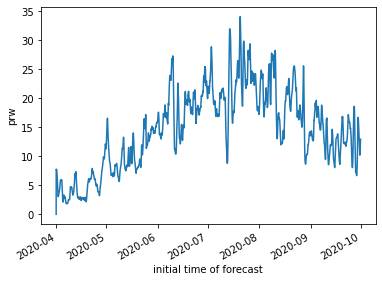

In [62]:
%%time
ds_rechunked.prw.isel(values=slice(100000, 110000)).mean("values").plot()

In [34]:
source_ds = xr.open_zarr(m)

<ipython-input-34-d69ede1fe289>:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  source_ds = xr.open_zarr(m)


CPU times: user 2min 1s, sys: 7.03 s, total: 2min 8s
Wall time: 3min 29s


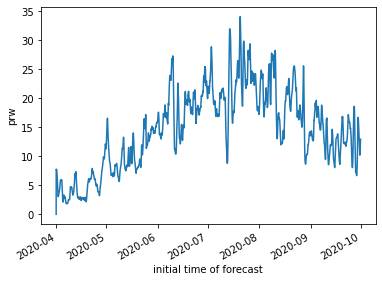

In [36]:
%%time
source_ds.prw.isel(values=slice(100000, 110000)).mean("values").plot()

In [43]:
%%time
source_ds.prw.isel(time=70).mean("values").values

CPU times: user 391 ms, sys: 42 ms, total: 433 ms
Wall time: 1.09 s


array(24.46917279)

In [44]:
%%time
ds_rechunked.prw.isel(time=70).mean("values").values

CPU times: user 378 ms, sys: 19 ms, total: 397 ms
Wall time: 429 ms


array(24.46917279)

In [46]:
ds_rechunked

<xarray.Dataset>
Dimensions:  (time: 8784, values: 20971520)
Dimensions without coordinates: time, values
Data variables:
    prw      (time, values) float64 dask.array<chunksize=(6, 262144), meta=np.ndarray>